In [1]:
import os
import re
import json

import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import anndata

#### integrated object cell type refinement

In [2]:
def remove_duplicates(a):
    """
    for some reason ended up with duplicate cells in adata object in subclustered objects
    
    this function just removes the duplicates
    """
    seen = set()
    keep = []
    for cell in a.obs.index.to_list():
        stem = re.sub(r'^(.*)_[0-9]+$', r'\1', cell)
        if stem not in seen:
            seen.add(stem)
            keep.append(cell)
    
    f = a[keep]
    f.obs.index = [re.sub(r'^(.*)_[0-9]+$', r'\1', x) for x in f.obs.index.to_list()]
    
    return f

In [14]:
sct = sc.read_h5ad('../data/single_cell/original/integrated_sct.h5ad')
sct

AnnData object with n_obs × n_vars = 113052 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.0.75', 'seurat_clusters', 'sample_id', 'cell_type'
    var: 'features', 'integrated_features'
    obsm: 'X_umap'
    layers: 'integrated'

In [3]:
# raw counts are raw.X
counts = sc.read_h5ad('../data/single_cell/original/integrated_rna.h5ad')
counts.var = counts.var.set_index('features')
counts

AnnData object with n_obs × n_vars = 113052 × 31915
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.0.75', 'seurat_clusters', 'sample_id', 'cell_type'
    var: '_index'
    obsm: 'X_umap'

In [4]:
cell_to_sample_id = {c:s if p=='NA' else p for c, s, p in zip(
    counts.obs.index.to_list(), counts.obs['sample_id'], counts.obs['Patient'])}
dataset_to_sample_id = {
    'in-house surgical': [
        '1555-tumor',
        'H_ZY-1105-07',
        'H_ZY-1160-06',
        'H_ZY-1174-06',
        'TWCE-HT055P-S1PAG',
        'TWCE-HT081P1-XB1'
    ],
    'lin': [
        'P01',
        'P02',
        'P03',
        'P04',
        'P05',
        'P06',
        'P07',
        'P08',
        'P09',
        'P10',
    ],
    'peng': [
        'T1',
        'T10',
        'T11',
        'T12',
        'T13',
        'T14',
        'T15',
        'T16',
        'T17',
        'T18',
        'T19',
        'T2',
        'T20',
        'T21',
        'T22',
        'T23',
        'T24',
        'T3',
        'T4',
        'T5',
        'T6',
        'T7',
        'T8',
        'T9',
    ],
    'chan-seng-yue': [
        '100070',
        '85948',
        '87235',
        '87784',
        '90209_CMP',
        '91412',
        '91610',
        '91706',
        '94930',
        '95092',
        '95373',
        '96460',
        '97727',
        'COMP_0158_P',
        'G9903',
    ]
}
sample_id_to_dataset = {v:k for k, vs in dataset_to_sample_id.items() for v in vs}
cell_to_dataset = {c:sample_id_to_dataset[cell_to_sample_id[c]] for c in counts.obs.index.to_list()}

In [27]:
gene_sets = json.load(open('../data/single_cell/gene_sets/pdac_gene_sets.json'))

In [28]:
imm_gene_sets = json.load(open('../data/single_cell/gene_sets/immune_gene_sets.json'))
gene_sets['MCPcounter'] = {k:v for k, v in imm_gene_sets.items() if 'MCPcounter' in k}
gene_sets['Immunophenogram'] = {k:v for k, v in imm_gene_sets.items() if 'Immunophenogram' in k}
gene_sets['CYT'] = {k:v for k, v in imm_gene_sets.items() if 'CYT' in k}

In [29]:
for k, v in gene_sets.items():
    print(k, v.keys())

Bailey dict_keys(['ADEX', 'Squamous-like', 'Pancreatic-Progenitor', 'Immunogenic'])
Collison dict_keys(['Exocrine-like', 'Quasi-Mesenchymal', 'Classical'])
Moffit dict_keys(['Basal', 'Classical'])
subTME dict_keys(['deserted', 'reactive'])
raghaven dict_keys(['scBasal', 'scClassical', 'IC', 'Pericyte-like', 'Fibroblast-like', 'Inflammatory', 'TAM-FCN1', 'TAM-C1QC', 'TAM-SPP1'])
elyada dict_keys(['myCAF', 'iCAF', 'apCAF'])
ben-porath dict_keys(['ES exp1', 'ES exp2', 'Nanog targets', 'Oct4 targets', 'Sox2 targets', 'NOS targets', 'NOS TFs', 'Suz12 targets', 'Eed targets', 'H3K27 bound', 'PRC2 targets', 'Myc targets1', 'Myc targets2', 'Genes functionally associated with proliferation', 'Cycling genes', 'Proliferation cluster', 'ES TFs'])
wong dict_keys(['stem_core'])
sanchez-vega dict_keys(['Cell Cycle', 'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF-Beta', 'RTK RAS', 'TP53', 'WNT'])
Chan-Seng-Yue dict_keys(['Signature 2 (Basal-like A)', 'Signature 10 (Basal-like B)', 'Signature 1 (Classic

#### save count data for copycat

In [168]:
for sample_id in sample_id_to_dataset.keys():
    f = counts[[c for c in counts.obs.index if cell_to_sample_id[c]==sample_id]]
    df = pd.DataFrame(data=f.X.toarray(), index=f.obs.index.to_list(), columns=f.var.index.to_list(), dtype=int)
    df = df.transpose()
#     df['gene'] = [g.split('.')[0] for g in df.index.to_list()]
    df['gene'] = df.index.to_list()
    df = df.groupby('gene').mean().astype(int)
    df.index.name = 'Gene'
    df = df[np.sum(df.values, axis=1)>0]
    # make columns readable by r
    df.columns = ['X' + x for x in df.columns]
    print(sample_id, df.shape)
    df.to_csv(f'../data/single_cell/copycat/inputs/{sample_id}.txt', sep='\t')
    

1555-tumor (18293, 3089)
H_ZY-1105-07 (20643, 4590)
H_ZY-1160-06 (16929, 1631)
H_ZY-1174-06 (19243, 13380)
TWCE-HT055P-S1PAG (18609, 2621)
TWCE-HT081P1-XB1 (20446, 4469)
P01 (14893, 565)
P02 (12307, 124)
P03 (16793, 722)
P04 (13013, 856)
P05 (16029, 738)
P06 (17702, 738)
P07 (17848, 1061)
P08 (18158, 1108)
P09 (16926, 842)
P10 (17394, 1519)
T1 (15478, 1171)
T10 (15271, 828)
T11 (16355, 3142)
T12 (15753, 2270)
T13 (16237, 2058)
T14 (15949, 1998)
T15 (16438, 1956)
T16 (16312, 1634)
T17 (16281, 2085)
T18 (15920, 1562)
T19 (16482, 2927)
T2 (15906, 3041)
T20 (15425, 482)
T21 (15520, 807)
T22 (15757, 2215)
T23 (16297, 2865)
T24 (16486, 1817)
T3 (15746, 1317)
T4 (15794, 1027)
T5 (15501, 1115)
T6 (16352, 1871)
T7 (15736, 747)
T8 (15271, 697)
T9 (15859, 2354)
100070 (18846, 2761)
85948 (19760, 2284)
87235 (18511, 2683)
87784 (18542, 2244)
90209_CMP (16863, 1517)
91412 (19120, 2308)
91610 (16435, 1238)
91706 (18644, 2603)
94930 (17398, 1359)
95092 (19011, 2529)
95373 (18741, 2353)
96460 (17378, 

###### malignant subtype identification

In [13]:
adata = sc.read_h5ad('../data/single_cell/original/integrated_subset_malignant.h5ad')
adata = remove_duplicates(adata)
adata

/diskmnt/Projects/Users/estorrs/miniconda3/envs/single-cell-pdac/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,


View of AnnData object with n_obs × n_vars = 50715 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.0.75', 'seurat_clusters', 'sample_id', 'cell_type', 'integrated_snn_res.1'
    var: 'features', 'SCT_features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'SCT'
    obsp: 'distances'

In [15]:
filtered_sct = anndata.AnnData(X=sct.raw[adata.obs.index].X,
                              obs=sct[adata.obs.index].obs)
filtered_sct.var.index = sct.raw.var['_index'].to_list()
filtered_sct

/diskmnt/Projects/Users/estorrs/miniconda3/envs/single-cell-pdac/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  


AnnData object with n_obs × n_vars = 50715 × 29227
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.0.75', 'seurat_clusters', 'sample_id', 'cell_type'

In [16]:
filtered_counts = counts[adata.obs.index.to_list()]
filtered_counts

View of AnnData object with n_obs × n_vars = 50715 × 31915
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.0.75', 'seurat_clusters', 'sample_id', 'cell_type'
    var: '_index'
    obsm: 'X_umap'

In [17]:
# save counts for cytotrace
df = pd.DataFrame(data=filtered_counts.X.toarray(), columns=filtered_counts.var.index.to_list(),
                  index=filtered_counts.obs.index.to_list(), dtype=int)
df = df.transpose()
df['gene'] = [g.split('.')[0] for g in df.index.to_list()]
df = df.groupby('gene').mean().astype(int)
df.index.name = 'Gene'
# make ids compatible with r
df.columns = ['X' + c for c in df.columns]
df

X1555-tumor_AAACCTGAGTGCGTGA-1  X1555-tumor_AAACGGGAGACAATAC-1  \
Gene                                                                           
7SK                                        0                               0   
A1BG                                       0                               0   
A1BG-AS1                                   0                               0   
A1CF                                       0                               0   
A2M                                        0                               0   
...                                      ...                             ...   
hsa-mir-1199                               0                               0   
hsa-mir-335                                0                               0   
hsa-mir-490                                0                               0   
hsa-mir-8072                               0                               0   
snoU13                                     0                               0   

              X1555-tumor_AACCATGGTACTTCTT-1  X1555-tumor_AACCATGTCCCTCAGT-1  \
Gene                                                                           
7SK                                        0                               0   
A1BG                                       0                               0   
A1BG-AS1                                   0                               0   
A1CF                                       0                               0   
A2M                                        0                               0   
...                                      ...                             ...   
hsa-mir-1199                               0                               0   
hsa-mir-335                                0                               0   
hsa-mir-490                                0                               0   
hsa-mir-8072                               0                               0   
snoU13                                     0                               0   

              X1555-tumor_AACCATGTCGTGGTCG-1  X1555-tumor_AACCGCGAGCAATCTC-1  \
Gene                                                                           
7SK                                        0                               0   
A1BG                                       0                               0   
A1BG-AS1                                   0                               0   
A1CF                                       0                               0   
A2M                                        0                               0   
...                                      ...                             ...   
hsa-mir-1199                               0                               0   
hsa-mir-335                                0                               0   
hsa-mir-490                                0                               0   
hsa-mir-8072                               0                               0   
snoU13                                     0                               0   

              X1555-tumor_AACCGCGTCTTTAGTC-1  X1555-tumor_AACTCAGAGTCTCGGC-1  \
Gene                                                                           
7SK                                        0                               0   
A1BG                                       0                               0   
A1BG-AS1                                   0                               0   
A1CF                                       0                               0   
A2M                                        0                               0   
...                                      ...                             ...   
hsa-mir-1199                               0                               0   
hsa-mir-335                                0                               0   
hsa-mir-490                                0                               0   
hsa-mir-807

In [18]:
for dataset in dataset_to_sample_id.keys():
    f = df[[c for c in df.columns if cell_to_dataset[c[1:]]==dataset]]
#     # filter for only nonzero
#     f = f[np.sum(df.values, axis=1)>0]
    print(dataset, f.shape)  
    df.to_csv(f'../data/single_cell/cytotrace/inputs/malignant_{dataset}.txt', sep='\t')

in-house surgical (28714, 11013)
lin (28714, 3671)
peng (28714, 13761)
chan-seng-yue (28714, 22270)


In [19]:
def score_signatures(a, gene_sets):
    for name, v in gene_sets.items():
        for gs, genes in v.items():
            ls = [g for g in genes if g in a.var.index.to_list()]
            sc.tl.score_genes(a, gene_list=ls,
                              score_name=f'{name} | {gs} score')

In [30]:
score_signatures(filtered_sct, {k:v for k, v in gene_sets.items()
                               if k in ['Bailey', 'Moffit', 'Collison', 'raghaven', 'Chan-Seng-Yue', 'ben-porath', 'wong']})

In [31]:
adata.obs = pd.merge(adata.obs, filtered_sct.obs[[c for c in filtered_sct.obs.columns if 'score' in c]],
                     left_index=True, right_index=True, how='left')
adata.obs

/diskmnt/Projects/Users/estorrs/miniconda3/envs/single-cell-pdac/lib/python3.7/site-packages/anndata/_core/anndata.py:859: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_df(value, "obs")


orig.ident nCount_RNA  \
1555-tumor_AAACCTGAGTGCGTGA-1                       1555-tumor      21400   
1555-tumor_AAACGGGAGACAATAC-1                       1555-tumor      18841   
1555-tumor_AACCATGGTACTTCTT-1                       1555-tumor       1773   
1555-tumor_AACCATGTCCCTCAGT-1                       1555-tumor        378   
1555-tumor_AACCATGTCGTGGTCG-1                       1555-tumor      32873   
...                                                        ...        ...   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCCA...       G9903      13837   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCGT...       G9903      22240   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCTC...       G9903      11128   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGGTTGT...       G9903      14543   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCATC...       G9903      20314   

                                                   nFeature_RNA  \
1555-tumor_AAACCTGAGTGCGTGA-1                              4292   
1555-tumor_AAACGGGAGACAATAC-1                              4128   
1555-tumor_AACCATGGTACTTCTT-1                               846   
1555-tumor_AACCATGTCCCTCAGT-1                               290   
1555-tumor_AACCATGTCGTGGTCG-1                              5222   
...                                                         ...   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCCA...         3158   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCGT...         4460   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCTC...         2857   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGGTTGT...         3749   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCATC...         3975   

                                                          percent.mt  \
1555-tumor_AAACCTGAGTGCGTGA-1                       6.10747663551402   
1555-tumor_AAACGGGAGACAATAC-1                       3.65691842258903   
1555-tumor_AACCATGGTACTTCTT-1                       10.1522842639594   
1555-tumor_AACCATGTCCCTCAGT-1                       9.52380952380952   
1555-tumor_AACCATGTCGTGGTCG-1                       24.1261825814498   
...                                                              ...   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCCA...   6.7211100672111   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCGT...  6.14208633093525   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCTC...  4.29547088425593   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGGTTGT...  2.79859726328818   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCATC...  13.8869745003446   

                                                   nCount_SCT nFeature_SCT  \
1555-tumor_AAACCTGAGTGCGTGA-1                            1480          691   
1555-tumor_AAACGGGAGACAATAC-1                            1397          710   
1555-tumor_AACCATGGTACTTCTT-1                            1520          845   
1555-tumor_AACCATGTCCCTCAGT-1                             935          347   
1555-tumor_AACCATGTCGTGGTCG-1                            1330          395   
...                                                       ...          ...   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCCA...      10637         3156   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCGT...      10967         3848   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGCGCTC...      10416         2857   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGGTTGT...      10860         3746   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCATC...      10833         3532   

                                                   CELL CONDITION Patient  \
1555-tumor_AAACCTGAGTGCGTGA-1                        NA        NA      NA   
1555-tumor_AAACGGGAGACAATAC-1                        NA        NA      NA   
1555-tumor_AACCATGGTACTTCTT-1                        NA        NA      NA   
1555-tumor_AACCATGTCCCTCAGT-1                        NA        NA      NA   
1555-tumor_AACCATGTCGTGGTCG-1                        NA        NA      NA   
...                                                 ...   

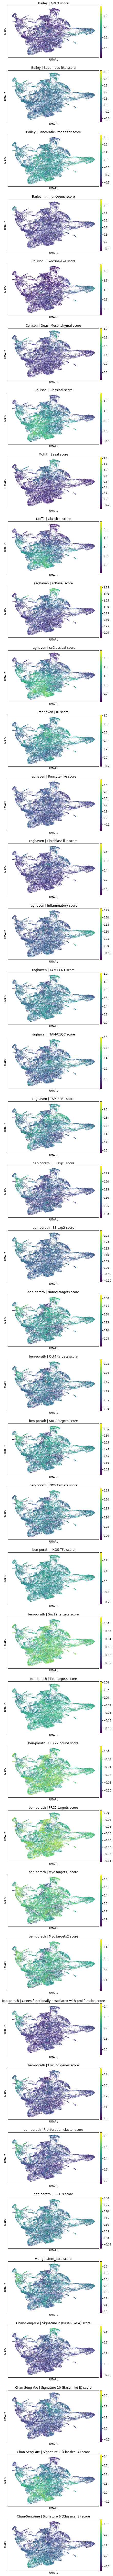

In [32]:
sc.pl.umap(adata, color=[c for c in adata.obs.columns if 'score' in c], ncols=1)

In [2]:
adata = sc.read_h5ad('../data/single_cell/original/integrated_integrated.h5ad')
adata

/diskmnt/Projects/Users/estorrs/miniconda3/envs/single-cell-pdac/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,


AnnData object with n_obs × n_vars = 113052 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.0.75', 'seurat_clusters', 'sample_id', 'cell_type'
    var: 'SCT_features', '_index', 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'SCT'
    obsp: 'distances'

In [84]:
len(set(counts_adata.obs.index))

113052

In [85]:
counts_adata.obs

orig.ident nCount_RNA  \
1555-tumor_AAACCTGAGACCTAGG-1                       1555-tumor       2931   
1555-tumor_AAACCTGAGTGCGTGA-1                       1555-tumor      21400   
1555-tumor_AAACCTGCATCCCACT-1                       1555-tumor        515   
1555-tumor_AAACCTGGTCATGCAT-1                       1555-tumor       1586   
1555-tumor_AAACCTGTCCGGGTGT-1                       1555-tumor       2631   
...                                                        ...        ...   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGGTTTC...       G9903       8237   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCAAG...       G9903       6484   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCACA...       G9903       8367   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCACA...       G9903      11476   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCATC...       G9903      20314   

                                                   nFeature_RNA  \
1555-tumor_AAACCTGAGACCTAGG-1                              1169   
1555-tumor_AAACCTGAGTGCGTGA-1                              4292   
1555-tumor_AAACCTGCATCCCACT-1                               340   
1555-tumor_AAACCTGGTCATGCAT-1                               689   
1555-tumor_AAACCTGTCCGGGTGT-1                              1049   
...                                                         ...   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGGTTTC...         2326   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCAAG...         1875   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCACA...         2286   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCACA...         3055   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCATC...         3975   

                                                          percent.mt  \
1555-tumor_AAACCTGAGACCTAGG-1                       5.83418628454452   
1555-tumor_AAACCTGAGTGCGTGA-1                       6.10747663551402   
1555-tumor_AAACCTGCATCCCACT-1                       4.66019417475728   
1555-tumor_AAACCTGGTCATGCAT-1                       19.1046658259773   
1555-tumor_AAACCTGTCCGGGTGT-1                       5.92930444697834   
...                                                              ...   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGGTTTC...  1.11691149690421   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCAAG...  1.09500308451573   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCACA...  2.85645990199594   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCACA...  1.81247821540606   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCATC...  13.8869745003446   

                                                   nCount_SCT nFeature_SCT  \
1555-tumor_AAACCTGAGACCTAGG-1                            1767         1057   
1555-tumor_AAACCTGAGTGCGTGA-1                            1480          691   
1555-tumor_AAACCTGCATCCCACT-1                            1090          366   
1555-tumor_AAACCTGGTCATGCAT-1                            1431          689   
1555-tumor_AAACCTGTCCGGGTGT-1                            1710          990   
...                                                       ...          ...   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGGTTTC...       9501         2326   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCAAG...       9275         1888   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCACA...       9493         2286   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCACA...      10490         3055   
G9903_filtered_gene_bc_matrices_h5.h5_TTTGTCATC...      10833         3532   

                                                   CELL CONDITION Patient  \
1555-tumor_AAACCTGAGACCTAGG-1                        NA        NA      NA   
1555-tumor_AAACCTGAGTGCGTGA-1                        NA        NA      NA   
1555-tumor_AAACCTGCATCCCACT-1                        NA        NA      NA   
1555-tumor_AAACCTGGTCATGCAT-1                        NA        NA      NA   
1555-tumor_AAACCTGTCCGGGTGT-1                        NA        NA      NA   
...                                                 ...   

In [24]:
# raw counts are raw.X
counts_adata = sc.read_h5ad('../data/single_cell/original/integrated_rna.h5ad')
counts_adata.var = counts_adata.var.set_index('features')
counts_adata

AnnData object with n_obs × n_vars = 113052 × 31915
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.0.75', 'seurat_clusters', 'sample_id', 'cell_type'
    var: '_index'
    obsm: 'X_umap'

In [25]:
counts_adata.var

_index
features                    
AL627309.1        AL627309.1
AL669831.5        AL669831.5
LINC00115          LINC00115
SAMD11                SAMD11
NOC2L                  NOC2L
...                      ...
RP11-403B2.6    RP11-403B2.6
RP11-1136G4.1  RP11-1136G4.1
AP005530.1        AP005530.1
AC008440.10      AC008440.10
AP000473.8        AP000473.8

[31915 rows x 1 columns]

In [9]:
set(counts_adata.raw.X[0].toarray().flatten())

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 29.0,
 31.0,
 33.0,
 34.0,
 41.0,
 52.0,
 58.0,
 67.0}

In [17]:
counts_adata.var

_index       features
0         AL627309.1     AL627309.1
1         AL669831.5     AL669831.5
2          LINC00115      LINC00115
3             SAMD11         SAMD11
4              NOC2L          NOC2L
...              ...            ...
31910   RP11-403B2.6   RP11-403B2.6
31911  RP11-1136G4.1  RP11-1136G4.1
31912     AP005530.1     AP005530.1
31913    AC008440.10    AC008440.10
31914     AP000473.8     AP000473.8

[31915 rows x 2 columns]

In [8]:
# X is scale.data from integrated assay and raw.X is data from integrated assay
adata = sc.read_h5ad('../data/single_cell/original/integrated_integrated.h5ad')
adata

/data/estorrs/miniconda3/envs/sc_pdac/lib/python3.7/site-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,


AnnData object with n_obs × n_vars = 113052 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.0.75', 'seurat_clusters', 'sample_id', 'cell_type'
    var: 'SCT_features', '_index', 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'SCT'
    obsp: 'distances'

In [14]:
adata.var

SCT_features     _index   features
0          SAMD11       SPP1       SPP1
1            HES4     COL1A1     COL1A1
2           ISG15        LUM        LUM
3        TNFRSF18        MGP        MGP
4         TNFRSF4      SFRP2      SFRP2
...           ...        ...        ...
2995     TP53TG3D  LINC00205  LINC00205
2996         CSF3      SYT11      SYT11
2997        PTPRT    BCL2L10    BCL2L10
2998        KCNB1   ATP6V1G2   ATP6V1G2
2999        CBLN4       KLF9       KLF9

[3000 rows x 3 columns]

In [16]:
adata.layers['SCT'].shape

(113052, 3000)

In [13]:
adata.raw.X.shape

(113052, 3000)

In [11]:
adata.layers['counts'] = counts_adata.raw.X

ValueError: Value passed for key 'counts' is of incorrect shape. Values of layers must match dimensions (0, 1) of parent. Value had shape (113052, 31915) while it should have had (113052, 3000).

In [3]:
adata.X

array([[-2.21198275, -2.44697471, -2.67837706, ..., -0.09416235,
        -0.07340713, -0.23156486],
       [-3.17365415, -2.19511218, -2.96876128, ..., -0.11958864,
        -0.1289242 , -0.59067   ],
       [-1.80783225, -1.67735685, -1.53501979, ..., -0.03703795,
        -0.31251288, -0.13506925],
       ...,
       [-1.92023382, 10.        , 10.        , ..., -0.09778932,
        -0.06233593, -0.82954187],
       [ 0.07365613, -2.21592259, -2.53493226, ...,  0.02935523,
        -0.18326476,  1.42124371],
       [-1.93877699, -2.70065107, -2.61501048, ..., -0.05858634,
        -0.06076754,  1.68742749]])

In [4]:
adata.layers['SCT']

array([[-0.07365578, -0.28201198, -0.64118657, ..., -0.01079224,
        -0.02593469, -0.00852385],
       [-0.15699102,  3.11789246, -0.67812708, ..., -0.04953781,
        -0.06826268, -0.04781286],
       [-0.03337659, -0.10653823, -0.36900279, ...,  0.00374125,
        -0.00983258,  0.00586419],
       ...,
       [-0.22245112,  0.54281014, -0.38986595, ..., -0.18769368,
        -0.09947098, -0.10806374],
       [-0.24002901, -0.83723332,  0.27987207, ..., -0.19848254,
        -0.10516399, -0.11461643],
       [-0.2755587 , -0.2214901 , -1.56272384, ..., -0.22003168,
        -0.11663569, -0.1277709 ]])

In [5]:
adata.raw.X

<113052x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 339156000 stored elements in Compressed Sparse Row format>

In [6]:
adata.raw.X[0].toarray()

array([[-2.54102635, -3.36626981, -3.49649925, ..., -0.06412523,
        -0.0756337 , -0.36814463]])

In [25]:
adata.var = adata.var.set_index('features')

SCT_features     _index
features                         
SPP1            SAMD11       SPP1
COL1A1            HES4     COL1A1
LUM              ISG15        LUM
MGP           TNFRSF18        MGP
SFRP2          TNFRSF4      SFRP2
...                ...        ...
LINC00205     TP53TG3D  LINC00205
SYT11             CSF3      SYT11
BCL2L10          PTPRT    BCL2L10
ATP6V1G2         KCNB1   ATP6V1G2
KLF9             CBLN4       KLF9

[3000 rows x 2 columns]

In [29]:
sc.tl.rank_genes_groups(adata, groupby='cell_type', groups=['UNK_immune'], use_raw=False)

/data/estorrs/miniconda3/envs/sc_pdac/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


In [30]:
adata.uns['rank_genes_groups']

{'params': {'groupby': 'cell_type',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('HMGB2',), ('STMN1',), ('CORO1A',), ..., ('SERPINA1',),
            ('S100A6',), ('C19orf33',)],
           dtype=[('UNK_immune', 'O')]),
 'scores': rec.array([( 108.40344,), (  79.76527,), (  53.02902,), ...,
            (-100.6699 ,), (-104.77608,), (-107.68163,)],
           dtype=[('UNK_immune', '<f4')]),
 'pvals': rec.array([(0.0000000e+000,), (1.0673687e-285,), (9.1856467e-207,), ...,
            (0.0000000e+000,), (0.0000000e+000,), (0.0000000e+000,)],
           dtype=[('UNK_immune', '<f8')]),
 'pvals_adj': rec.array([(0.00000000e+000,), (3.07894816e-284,), (1.46579469e-205,),
            ..., (0.00000000e+000,), (0.00000000e+000,),
            (0.00000000e+000,)],
           dtype=[('UNK_immune', '<f8')]),
 'logfoldchanges': rec.array([(      nan,), (      nan,), (      nan,), ..., (1.7532507,),
    